In [ ]:
# useful links
# Betsy - https://stats.idre.ucla.edu/stata/seminars/regression-models-with-count-data/
# https://stats.idre.ucla.edu/r/dae/zinb/
# https://stats.idre.ucla.edu/stata/output/zero-inflated-negative-binomial-regression/
# https://towardsdatascience.com/an-illustrated-guide-to-the-zero-inflated-poisson-model-b22833343057
# https://towardsdatascience.com/negative-binomial-regression-f99031bb25b4

#https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html

In [59]:
from __future__ import print_function

# Import libraries
import pandas as pd
import numpy as np
import datetime as dt
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats
from patsy import dmatrices

# For interactive widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# turn off top and rigt axis line in matplotlib
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

# change font size in matplolib
plt.rcParams.update({'font.size': 16})

# increasing the deafult DPI to improve resolution
#plt.rcParams['figure.dpi']= 50 # for preview
plt.rc("savefig", dpi = 300) # for saving

Naming convention for dataframes:

* sd - Secchi disk depth

* t - turbidity

* tss - total suspended solids

* c - chlorophyll

* tcc - total cell count

    * tcc_c - total cell count (composite)
    
    * tcc_s - total cell count (surface)

* tb - total biovolume

    * tb_c - total biovolume (composite)
    
    * tb_s - total biovolume (surface)

* ccc - cyano cell count

    * ccc_c - cyano cell count (composite)
    
    * ccc_s - cyano cell count (surface)

* cb - cyano biovolume

    * cb_c - cyano biovolume (composite)
    
    * cb_s - cyano biovolume (surface)

In [18]:
# Locate folder with csv for each variable
data_folder = "../../data/processed/regression/"
files = os.listdir(data_folder)

In [19]:
# Check CSV files in the folder
files

['chlorophyll_final.csv',
 'cyano_biovolume_composite_final.csv',
 'cyano_biovolume_final.csv',
 'cyano_biovolume_surface_final.csv',
 'cyano_cell_count_composite_final.csv',
 'cyano_cell_count_final.csv',
 'cyano_cell_count_surface_final.csv',
 'secchi_depth_final.csv',
 'total_biovolume_composite_final.csv',
 'total_biovolume_final.csv',
 'total_biovolume_surface_final.csv',
 'total_cell_count_composite_final.csv',
 'total_cell_count_final.csv',
 'total_cell_count_surface_final.csv',
 'total_suspended_solids_final.csv',
 'turbidity_final.csv',
 'tweets_daily_final.csv']

In [20]:
# Create a dictionary to hold all the dataframes
df = {}

# Name of dataframe indices - align with the order of files
names = ["c", "cb_c", "cb", "cb_s", "ccc_c", "ccc", "ccc_s", "sd", "tb_c", 
         "tb", "tb_s", "tcc_c", "tcc", "tcc_s", "tss", "t", "tweets"]

In [21]:
# Import data
for name, file in zip(names, files):
        df[name] = pd.read_csv(f'{data_folder}{file}')

In [22]:
# Convert date column to datetime object
for file in df.keys():
    # seaprate if statement for tweets dataframe because its date column has a different name
    if file == "tweets":
        df[file]['time'] = pd.to_datetime(df[file]['time'])
    else:
        df[file]["OBJECTID_1"] = pd.to_datetime(df[file]["OBJECTID_1"])
        df[file].columns = df[file].columns.str.replace(".", "")
    

In [23]:
# Merge various tweet count stats with each dataframe

for file in df.keys():

    # Apply following steps in all the dataframes except the one for tweet counts per day
    if file != "tweets":
    
        # create new columns to store tweet counts data

        df[file]['tweets_neg_3_both'] = np.nan
        df[file]['tweets_neg_3_after'] = np.nan
        df[file]['tweets_neg_7_both'] = np.nan
        df[file]['tweets_neg_7_after'] = np.nan


        # Iterate over each row in wq variable
        for index, row in df[file].iterrows():

            # get dates for which we have water quality measurements
            date_wq = row['OBJECTID_1']

            # get index of the row with same date in the tweets data
            tweets_index = df["tweets"]['time'].eq(date_wq).idxmax()

            # get tweets info from 3 & 7 days before and after the date on which water quality was measured
            tweets_result_3_both = df["tweets"].iloc[tweets_index-3: tweets_index+4]
            tweets_result_3_after = df["tweets"].iloc[tweets_index: tweets_index+4]

            tweets_result_7_both = df["tweets"].iloc[tweets_index-7: tweets_index+8]
            tweets_result_7_after = df["tweets"].iloc[tweets_index: tweets_index+8]

            # assign the sum of negative tweets
            df[file].loc[index, 'tweets_neg_3_both'] = tweets_result_3_both['neg'].sum() 
            df[file].loc[index, 'tweets_neg_3_after'] = tweets_result_3_after['neg'].sum() 
            df[file].loc[index, 'tweets_neg_7_both'] = tweets_result_7_both['neg'].sum() 
            df[file].loc[index, 'tweets_neg_7_after'] = tweets_result_7_after['neg'].sum()

# Statistical Analysis

Lets create functions to apply similar processes for all of our explanatory water qauality variables

In [24]:
# Creat histogram of tweet counts for all water quality variables to see if they are zero-inflated
# separate functions for 3 days and 7 days rolling windows
 
# 7 days rolling window
def histogram_7days(variable, plot_title):
    fig = plt.figure(figsize=(15,12))
    i = -1

    for num in range(1,10):

        ax1 = fig.add_subplot(3,3,num)
        ax1.hist(variable.iloc[:,i], color='lightskyblue', linewidth=1, edgecolor="white", bins=40)
        ax1.set(xlabel = variable.columns[i], ylabel=f'Number of observations')
        i-=1

    fig.suptitle(f"Distribution of total tweets in 7-day rolling window for {plot_title}, n={len(variable)}")
    #fig.tight_layout()
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.savefig(f"../../output/distribution/{plot_title}_7d_histogram.png", bbox_inches = 'tight')
    
# 3 days rolling window
def histogram_3days(variable, plot_title):
    fig = plt.figure(figsize=(15,12))
    i = -10

    for num in range(1,10):

        ax1 = fig.add_subplot(3,3,num)
        ax1.hist(variable.iloc[:,i], color='pink', linewidth=1, edgecolor="white", bins=40)
        ax1.set(xlabel = variable.columns[i], ylabel=f'Number of observations')
        i-=1

    fig.suptitle(f"Distribution of total tweets in 3-day rolling window for {plot_title}, n={len(variable)}")
    #fig.tight_layout()
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.savefig(f"../../output/distribution/{plot_title}_3d_histogram.png", bbox_inches = 'tight')
    


In [25]:
# Perform poisson regresion
def poisson(wq, x, y):
    
    temp = df[wq]
    
    # Model formula
    formula = f"{y} ~ {x}"
    
    # Use Patsy package to carve out the x and y matrices for the ZIP model 
    Y, X = dmatrices(formula, temp, return_type='dataframe')
    
    # Fit the model
    model_p = sm.GLM(Y, X, family=sm.families.Poisson()).fit() #Fit the model using maximum likelihood
    
    return model_p.summary()

#-----------------------------------------------------------------------

# Perform negative binomial
# following poisson results will feed into negative binomial
def poisson_for_nb(wq, x, y):
    
    temp = df[wq]
    
    # Model formula
    formula = f"{y} ~ {x}"
    
    # Use Patsy package to carve out the x and y matrices for the ZIP model 
    Y, X = dmatrices(formula, temp, return_type='dataframe')
    
    # Fit the model
    model_p = sm.GLM(Y, X, family=sm.families.Poisson()).fit() #Fit the model using maximum likelihood
    
    return model_p, Y, X, temp

def negative_binomial(wq, x, y):
    
    model_p, Y, X, temp = poisson_for_nb(wq, x, y)
    
    # Obtain rate vector from Poisson model
    temp2 = temp.copy()
    temp2['rate_lambda'] = model_p.mu
    
    # Auxiliary OLS regression to find α for the NB2 model
    # Calculate the dependent variable
    temp2['aux_ols_dependent'] = temp2.apply(lambda t: ((t[y] - t['rate_lambda'])**2 - t['rate_lambda']) / t['rate_lambda'], axis=1)
    
    # Using the α as dependent variable in an OLS regression model
    ols_formula = """aux_ols_dependent ~ rate_lambda - 1"""
    
    # Fitting the OLS regression model
    model_aux_olsr = smf.ols(ols_formula, temp2).fit()
    
    # The model coefficient is the alpha parameter for our negative binomial
    alpha = model_aux_olsr.params[0]
    
    # Get the associate t-value to determine significance
    t_value = model_aux_olsr.tvalues[0]
    
    # Caluclate degrees of freedom (number of observations - regression variables - dispersion variable)
    deg_freedom = len(temp2) - 1 - 1
    
    # Determine t critical value at 95% significance value
    t_critical = scipy.stats.t.ppf(q=1-.05,df=deg_freedom)
    
    # If the alpha is significant, negative binomial can be a better fit than poisson
    if (t_value > t_critical):
        alpha_sig = "Alpha parameter of negative binomial regression is significant"
    else:
        alpha_sig = "Alpha parameter of negative binomial regression is not significant"
        
    # Fit negative binomial regression model
    model_nb = sm.GLM(Y, X,family=sm.families.NegativeBinomial(alpha=alpha)).fit()
    
#     # Export model as img
#     plt.rc('figure', figsize=(7,3))
#     plt.text(0.01, 0.05, str(nb2_training_results.summary()),
#     {'fontsize':22}, fontproperties =  'monospace')
#     plt.axis('off')
#     plt.tight_layout()
#     plt.savefig(f'../../output/regression/{wq}_{y}_summary.png')
    
    return alpha_sig, model_nb.summary(), model_nb

#-------------------------------------------------------

# Perform zero inflated poisson regression (ZIP)
def zero_inflated_poisson(water_quality_parameter, alias, independent_var, dependent_var):
    
    display(alias)
    
    # Model formula
    formula = f"{dependent_var} ~ {independent_var}"
    
    # Use Patsy package to carve out the x and y matrices for the ZIP model 
    y, x = dmatrices(formula, water_quality_parameter, return_type='dataframe')
    
    # Fit the model
    model_zip = sm.ZeroInflatedPoisson(endog=y, exog=x, exog_infl=x, inflation='logit').fit(maxiter=500, method='bfgs') #Fit the model using maximum likelihood
    
    return model_zip.summary()

In [26]:
# Run either poisson or negative binmoial using widgets
def regression_choice (Model, wq, x, y):
    print(f"{Model} - {y}")
    if Model == "Negative Binomial":
        return negative_binomial(wq, x, y)
    elif Model == "Poisson":
        return poisson(wq, x, y)
    

# Exploratory model widget - Create interactive UI to run the statistical model
def explore_models(): #FOR NOW THIS WORKS WITH THE POISSON FUNCTION BELOW

    interact_manual(regression_choice, Model = [("Negative Binomial", 'Negative Binomial'), ("Poisson", 'Poisson')],
                    wq = [("Secchi disk depth", 'sd'), ("Chlorophyll a", 'c'), 
                          ("Total suspended solids", 'tss'),("Turbidity", 't'),
                          ("Phytoplankton cell count", 'tcc'), ("Phytoplankton biovolume", 'tb'),
                          ("Phytoplankton cell count (Composite)", 'tcc_c'), ("Phytoplankton cell count (Surface)", 'tcc_s'), 
                          ("Phytoplankton biovolume (Composite)", 'tb_c'), ("Phytoplankton biovolume (Surface)", 'tb_s'),
                          ("Cyanobacteria cell count", 'ccc'), ("Cyanobacteria biovolume", 'cb'),
                          ("Cyanobacteria cell count (Composite)", 'ccc_c'), ("Cyanobacteria cell count (Surface)", 'ccc_s'),
                          ("Cyanobacteria biovolume (Composite)", 'cb_c'), ("Cyanobacteria biovolume (Surface)", 'cb_s')],
                x = [("75th percentile", 'X75'),("Median", 'X50'),
                    ("Mean", 'MEAN'), ("25th percentile", 'X25')], 
                     
                 y = [("Negative tweet counts in 3 prior days", 'tweets_neg_3_before'),
                      ("Negative tweet counts in 3 following days", 'tweets_neg_3_after'),
                      ("Negative tweet counts in 3 days rolling window", 'tweets_neg_3_both'),
                      ("Negative tweet counts in 7 prior days", 'tweets_neg_7_before'),
                      ("Negative tweet counts in 7 following days", 'tweets_neg_7_after'),
                      ("Negative tweet counts in 7 days rolling window", 'tweets_neg_7_both'),
                      ("---------------------------------------------", ''),
                      ("Total tweet counts in 3 prior days", 'tweets_wq_3_before'),
                      ("Total tweet counts in 3 following days", 'tweets_wq_3_after'),
                      ("Total tweet counts in 3 days rolling window", 'tweets_wq_3_both'),
                      ("Total tweet counts in 7 prior days", 'tweets_wq_7_before'),
                      ("Total tweet counts in 7 following days", 'tweets_wq_7_after'),
                      ("Total tweet counts in 7 days rolling window", 'tweets_wq_7_both'),
                      ("---------------------------------------------", ''),
                      ("Positive tweet counts in 3 prior days", 'tweets_pos_3_before'),
                      ("Positive tweet counts in 3 following days", 'tweets_pos_3_after'),
                      ("Positive tweet counts in 3 days rolling window", 'tweets_pos_3_both'),
                      ("Positive tweet counts in 7 prior days", 'tweets_pos_7_before'),
                      ("Positive tweet counts in 7 following days", 'tweets_pos_7_after'),
                      ("Positive tweet counts in 7 days rolling window", 'tweets_pos_7_both'),
                                  ]);

In [11]:
# Run negative binmoial for all possible dependent variables (negative and total sentiment for now)
def mass_regression (wq):
    
    # 75th percentile
    x = 'X75'
    
    y = [("Negative tweet counts in 3 prior days", 'tweets_neg_3_before'),
          ("Negative tweet counts in 3 following days", 'tweets_neg_3_after'),
          ("Negative tweet counts in 3 days rolling window", 'tweets_neg_3_both'),
          ("Negative tweet counts in 7 prior days", 'tweets_neg_7_before'),
          ("Negative tweet counts in 7 following days", 'tweets_neg_7_after'),
          ("Negative tweet counts in 7 days rolling window", 'tweets_neg_7_both'),
          ("Total tweet counts in 3 prior days", 'tweets_wq_3_before'),
          ("Total tweet counts in 3 following days", 'tweets_wq_3_after'),
          ("Total tweet counts in 3 days rolling window", 'tweets_wq_3_both'),
          ("Total tweet counts in 7 prior days", 'tweets_wq_7_before'),
          ("Total tweet counts in 7 following days", 'tweets_wq_7_after'),
          ("Total tweet counts in 7 days rolling window", 'tweets_wq_7_both') #,
#           ("Positive tweet counts in 3 prior days", 'tweets_pos_3_before'),
#           ("Positive tweet counts in 3 following days", 'tweets_pos_3_after'),
#           ("Positive tweet counts in 3 days rolling window", 'tweets_pos_3_both'),
#           ("Positive tweet counts in 7 prior days", 'tweets_pos_7_before'),
#           ("Positive tweet counts in 7 following days", 'tweets_pos_7_after'),
#           ("Positive tweet counts in 7 days rolling window", 'tweets_pos_7_both'),
        ]
    
    y1 = negative_binomial(wq, x, 'tweets_neg_3_before')
    y1_name = f"Negative Binomial - {y[0][0]}"
    
    y2 = negative_binomial(wq, x, 'tweets_neg_3_after')
    y2_name = f"Negative Binomial - {y[1][0]}"
    
    y3 = negative_binomial(wq, x, 'tweets_neg_3_both')
    y3_name = f"Negative Binomial - {y[2][0]}"
    
    y4 = negative_binomial(wq, x, 'tweets_neg_7_before')
    y4_name = f"Negative Binomial - {y[3][0]}"
    
    y5 = negative_binomial(wq, x, 'tweets_neg_7_after')
    y5_name = f"Negative Binomial - {y[4][0]}"
    
    y6 = negative_binomial(wq, x, 'tweets_neg_7_both')
    y6_name = f"Negative Binomial - {y[5][0]}"
    
    y7 = negative_binomial(wq, x, 'tweets_neg_3_before')
    y7_name = f"Negative Binomial - {y[6][0]}"
    
    y8 = negative_binomial(wq, x, 'tweets_neg_3_after')
    y8_name = f"Negative Binomial - {y[7][0]}"
    
    y9 = negative_binomial(wq, x, 'tweets_neg_3_both')
    y9_name = f"Negative Binomial - {y[8][0]}"
    
    y10 = negative_binomial(wq, x, 'tweets_neg_7_before')
    y10_name = f"Negative Binomial - {y[9][0]}"
    
    y11 = negative_binomial(wq, x, 'tweets_neg_7_after')
    y11_name = f"Negative Binomial - {y[10][0]}"
    
    y12 = negative_binomial(wq, x, 'tweets_neg_7_both')
    y12_name = f"Negative Binomial - {y[11][0]}"
    
    
    
    return display(y1_name, y1[0], y1[1]), display(y2_name, y2[0], y2[1]), display(y3_name, y3[0], y3[1]), display(y4_name, y4[0], y4[1]), display(y5_name, y5[0], y5[1]), display(y6_name, y6[0], y6[1]), display(y7_name, y7[0], y7[1]), display(y8_name, y8[0], y8[1]), display(y9_name, y9[0], y9[1]), display(y10_name, y10[0], y10[1]), display(y11_name, y11[0], y11[1]), display(y12_name, y12[0], y12[1])   

In [12]:
# Automate mass-run model widget - Create interactive UI to run the statistical model
def run_models(): #FOR NOW THIS WORKS WITH THE POISSON FUNCTION BELOW

    interact_manual(mass_regression, wq = [("Secchi disk depth", 'sd'), ("Chlorophyll a", 'c'), 
                          ("Total suspended solids", 'tss'),("Turbidity", 't'),
                          ("Phytoplankton cell count", 'tcc'), ("Phytoplankton biovolume", 'tb'),
                          ("Phytoplankton cell count (Composite)", 'tcc_c'), ("Phytoplankton cell count (Surface)", 'tcc_s'), 
                          ("Phytoplankton biovolume (Composite)", 'tb_c'), ("Phytoplankton biovolume (Surface)", 'tb_s'),
                          ("Cyanobacteria cell count", 'ccc'), ("Cyanobacteria biovolume", 'cb'),
                          ("Cyanobacteria cell count (Composite)", 'ccc_c'), ("Cyanobacteria cell count (Surface)", 'ccc_s'),
                          ("Cyanobacteria biovolume (Composite)", 'cb_c'), ("Cyanobacteria biovolume (Surface)", 'cb_s')]) #,
#                 x = [("75th percentile", 'X75'),("Median", 'X50'),
#                     ("Mean", 'MEAN'), ("25th percentile", 'X25')], 
                     
                 

In [13]:
# Get p-values for each model
def get_pvalues():
    
    # Create an empty dictionary to hold p-value
    pvalues = {}
    
    wq = ["c", "cb_c", "cb", "cb_s", "ccc_c", "ccc", "ccc_s", "sd", "tb_c", 
         "tb", "tb_s", "tcc_c", "tcc", "tcc_s", "tss", "t"]
    
    x = 'X75'
    
    y =  ['tweets_neg_3_after',
          'tweets_neg_3_both',
          'tweets_neg_7_after',
          'tweets_neg_7_both',
        ]
    
    # Iterate through each water quality parameter
    for i in wq:
        
        # Iterate through each possible independent variable
        for j in y:
            
            # Calculate pvalue using the third return object[model.fit() NOT model.fit().summary()] from negative binomial function
            # 3 decimal places only
            pvalues[f"{i}_{j}"] = negative_binomial(i, x, j)[2].pvalues[1]
                      
    return pvalues
            
# Store pvalue dictionary to a new variable 
pvalues = get_pvalues()

In [14]:
# Round p-values to 3 decimal places
for key in pvalues:
    pvalues[key] = round(pvalues[key], 3) 

In [15]:
# Make a list of p-values to make a dataframe that can be exported
sd = [pvalues['sd_tweets_neg_3_after'], pvalues['sd_tweets_neg_3_both'], 
      pvalues['sd_tweets_neg_7_after'], pvalues['sd_tweets_neg_7_both']]

t  = [pvalues['t_tweets_neg_3_after'], pvalues['t_tweets_neg_3_both'], 
      pvalues['t_tweets_neg_7_after'], pvalues['t_tweets_neg_7_both']]

c  = [pvalues['c_tweets_neg_3_after'], pvalues['c_tweets_neg_3_both'], 
      pvalues['c_tweets_neg_7_after'], pvalues['c_tweets_neg_7_both']]

tss =[pvalues['tss_tweets_neg_3_after'], pvalues['tss_tweets_neg_3_both'], 
      pvalues['tss_tweets_neg_7_after'], pvalues['tss_tweets_neg_7_both']]

tcc = [pvalues['tcc_tweets_neg_3_after'], pvalues['tcc_tweets_neg_3_both'], 
       pvalues['tcc_tweets_neg_7_after'], pvalues['tcc_tweets_neg_7_both']]

tcc_c = [pvalues['tcc_c_tweets_neg_3_after'], pvalues['tcc_c_tweets_neg_3_both'], 
         pvalues['tcc_c_tweets_neg_7_after'], pvalues['tcc_c_tweets_neg_7_both']]

tcc_s = [pvalues['tcc_s_tweets_neg_3_after'], pvalues['tcc_s_tweets_neg_3_both'], 
         pvalues['tcc_s_tweets_neg_7_after'], pvalues['tcc_s_tweets_neg_7_both']]

tb  = [pvalues['tb_tweets_neg_3_after'], pvalues['tb_tweets_neg_3_both'], 
       pvalues['tb_tweets_neg_7_after'], pvalues['tb_tweets_neg_7_both']]

tb_c =  [pvalues['tb_c_tweets_neg_3_after'], pvalues['tb_c_tweets_neg_3_both'], 
         pvalues['tb_c_tweets_neg_7_after'], pvalues['tb_c_tweets_neg_7_both']]

tb_s =  [pvalues['tb_s_tweets_neg_3_after'], pvalues['tb_s_tweets_neg_3_both'], 
         pvalues['tb_s_tweets_neg_7_after'], pvalues['tb_s_tweets_neg_7_both']]
  
ccc = [pvalues['ccc_tweets_neg_3_after'], pvalues['ccc_tweets_neg_3_both'], 
       pvalues['ccc_tweets_neg_7_after'], pvalues['ccc_tweets_neg_7_both']]

ccc_c = [pvalues['ccc_c_tweets_neg_3_after'], pvalues['ccc_c_tweets_neg_3_both'], 
         pvalues['ccc_c_tweets_neg_7_after'], pvalues['ccc_c_tweets_neg_7_both']]

ccc_s = [pvalues['ccc_s_tweets_neg_3_after'], pvalues['ccc_s_tweets_neg_3_both'], 
         pvalues['ccc_s_tweets_neg_7_after'], pvalues['ccc_s_tweets_neg_7_both']]

cb  = [pvalues['cb_tweets_neg_3_after'], pvalues['cb_tweets_neg_3_both'], 
       pvalues['cb_tweets_neg_7_after'], pvalues['cb_tweets_neg_7_both']]

cb_c =  [pvalues['cb_c_tweets_neg_3_after'], pvalues['cb_c_tweets_neg_3_both'], 
         pvalues['cb_c_tweets_neg_7_after'], pvalues['cb_c_tweets_neg_7_both']]

cb_s =  [pvalues['cb_s_tweets_neg_3_after'], pvalues['cb_s_tweets_neg_3_both'], 
         pvalues['cb_s_tweets_neg_7_after'], pvalues['cb_s_tweets_neg_7_both']]

In [ ]:
# Create a dataframe of p-values from the lists above
df_pvalues = pd.DataFrame([sd, t, c, tss, tcc, tcc_c, tcc_s, tb, tb_c, tb_s, ccc, ccc_c, ccc_s, cb, cb_c, cb_s],
                          index = ['Secchi disk depth', 'Turbidity', 'Chlorophyll', 'Total suspended solids',
                          'Phytoplankton cell count', 'Phytoplankton cell count (Composite)', 
                          'Phytoplankton cell count (Surface)', 'Phytoplankton biovolume', 
                          'Phytoplankton biovolume (Composite)', 'Phytoplankton biovolume (Surface)',
                          'Cyanobacteria cell count', 'Cyanobacteria cell count (Composite)', 
                          'Cyanobacteria cell count (Surface)', 'Cyanobacteria biovolume', 
                          'Cyanobacteria biovolume (Composite)', 'Cyanobacteria biovolume (Surface)'],
                          columns = ['tweets_neg_3_after', 'tweets_neg_3_both',
                                    'tweets_neg_7_after', 'tweets_neg_7_both']
                         )

# Export
#df_pvalues.to_csv("../../output/regression/pvalues.csv")

# Bivariate plots

In [86]:
# Create a function to make bivariate plots
def bivariate_plot(variable, name, unit, col):
    fig = plt.figure(figsize=(12,11))

    ax1 = fig.add_subplot(2, 2, 1)
    ax1.scatter(df[variable]['X75'], df[variable]['tweets_neg_3_after'], color=col, 
               alpha=0.5, s=100, edgecolor='black')
    ax1.set(xlabel=f"{name} ({unit})", ylabel='Tweet counts',
           title="3 days after")

    ax1 = fig.add_subplot(2, 2, 2)
    ax1.scatter(df[variable]['X75'], df[variable]['tweets_neg_3_both'], color=col, 
               alpha=0.5, s=100, edgecolor='black')
    ax1.set(xlabel=f"{name} ({unit})", ylabel='Tweet counts', 
            title="3 days before and after")

    ax1 = fig.add_subplot(2, 2, 3)
    ax1.scatter(df[variable]['X75'], df[variable]['tweets_neg_7_after'], color=col, 
               alpha=0.5, s=100, edgecolor='black')
    ax1.set(xlabel=f"{name} ({unit})", ylabel='Tweet counts',
           title="7 days after")

    ax1 = fig.add_subplot(2, 2, 4)
    ax1.scatter(df[variable]['X75'], df[variable]['tweets_neg_7_both'], color=col, 
               alpha=0.5, s=100, edgecolor='black')
    ax1.set(xlabel=f"{name} ({unit})", ylabel='Tweet counts',
           title="7 days before and after")


    fig.suptitle(f"Rolling sum of tweets for Secchi disk depth (n={len(df[variable])}) measurements")
    #fig.tight_layout()
    plt.subplots_adjust(hspace=0.4, wspace=0.2)
    plt.savefig(f"../../output/bivariate plots/{variable}_plot.png", bbox_inches = 'tight')
    plt.show();

## Secchi disk depth

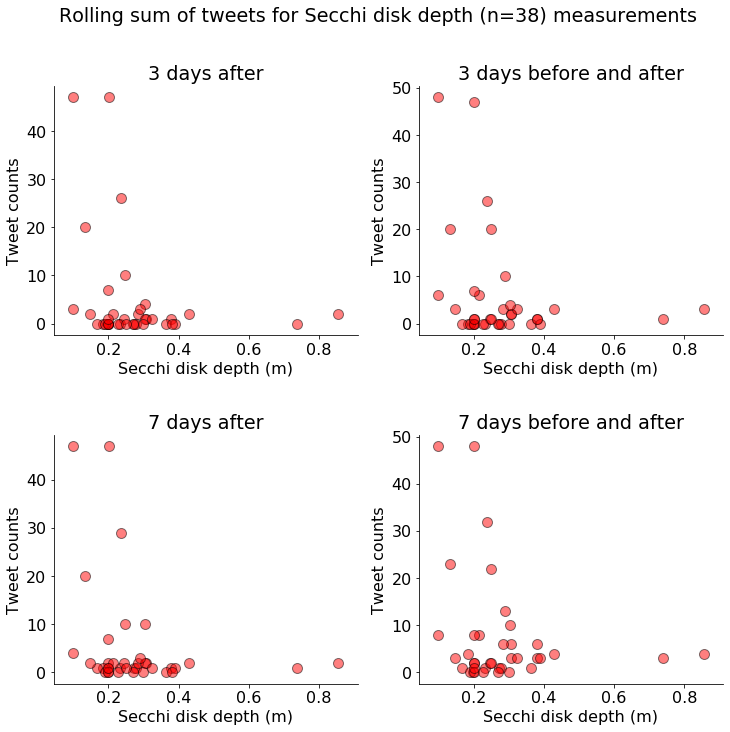

In [87]:
bivariate_plot('sd', 'Secchi disk depth', 'm', 'red')

# Turbidity

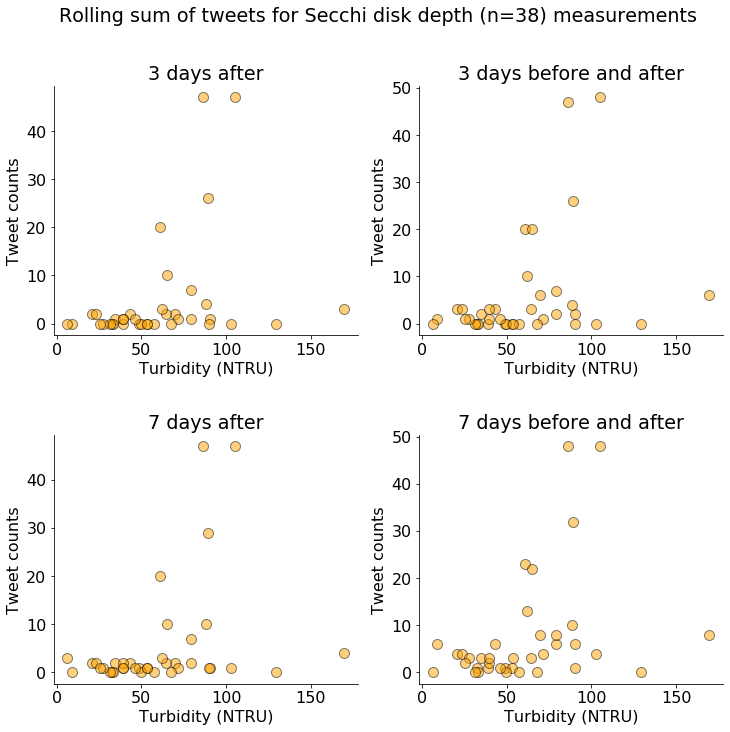

In [89]:
bivariate_plot('t', 'Turbidity', 'NTRU', 'orange')

In [28]:
def histogram_3days(variable, plot_title):
    fig = plt.figure(figsize=(15,12))
    i = -10

    for num in range(1,10):

        ax1 = fig.add_subplot(3,3,num)
        ax1.hist(variable.iloc[:,i], color='pink', linewidth=1, edgecolor="white", bins=40)
        ax1.set(xlabel = variable.columns[i], ylabel=f'Number of observations')
        i-=1

    fig.suptitle(f"Distribution of total tweets in 3-day rolling window for {plot_title}, n={len(variable)}")
    #fig.tight_layout()
    plt.subplots_adjust(hspace=0.5, wspace=0.3)

,OID,OBJECTID_1,COUNT,AREA,MEAN,STD,SUM,X25,X50,X75,tweets_neg_3_both,tweets_neg_3_after,tweets_neg_7_both,tweets_neg_7_after
0,0,2016-04-20,27254.0,0.036135,0.326584,0.065224,8900.717586,0.292608,0.326837,0.379791,1.0,1.0,3.0,1.0
1,1,2016-05-25,27254.0,0.036135,0.200000,0.000000,5450.800081,0.200000,0.200000,0.200000,1.0,0.0,2.0,1.0
2,2,2016-06-30,27254.0,0.036135,0.200000,0.000000,5450.800081,0.200000,0.200000,0.200000,0.0,0.0,2.0,2.0
3,3,2017-05-10,27254.0,0.036135,0.266793,0.010521,7271.177156,0.256585,0.267754,0.272464,0.0,0.0,1.0,1.0
4,4,2017-05-11,27254.0,0.036135,0.271572,0.011862,7401.413938,0.265434,0.269956,0.278423,0.0,0.0,1.0,1.0



## For some parameters zero-inflated poisson is not working...
## for same reason zero-inflated negative binomial wasn't working

# I. Secchi disk depth

## Tweet distributions

In [ ]:
display(histogram_3days(df["sd"], "Secchi disk depth"));
display(histogram_7days(df["sd"], "Secchi disk depth"));

## Models

interactive(children=(Dropdown(description='wq', options=(('Secchi disk depth', 'sd'), ('Chlorophyll a', 'c'),…

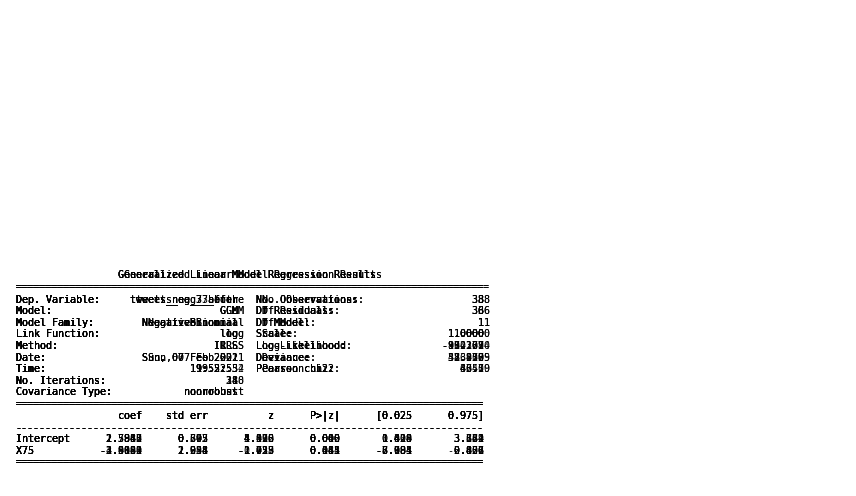

In [14]:
run_models()

# II. Turbidity

## Tweet distributions

None

None

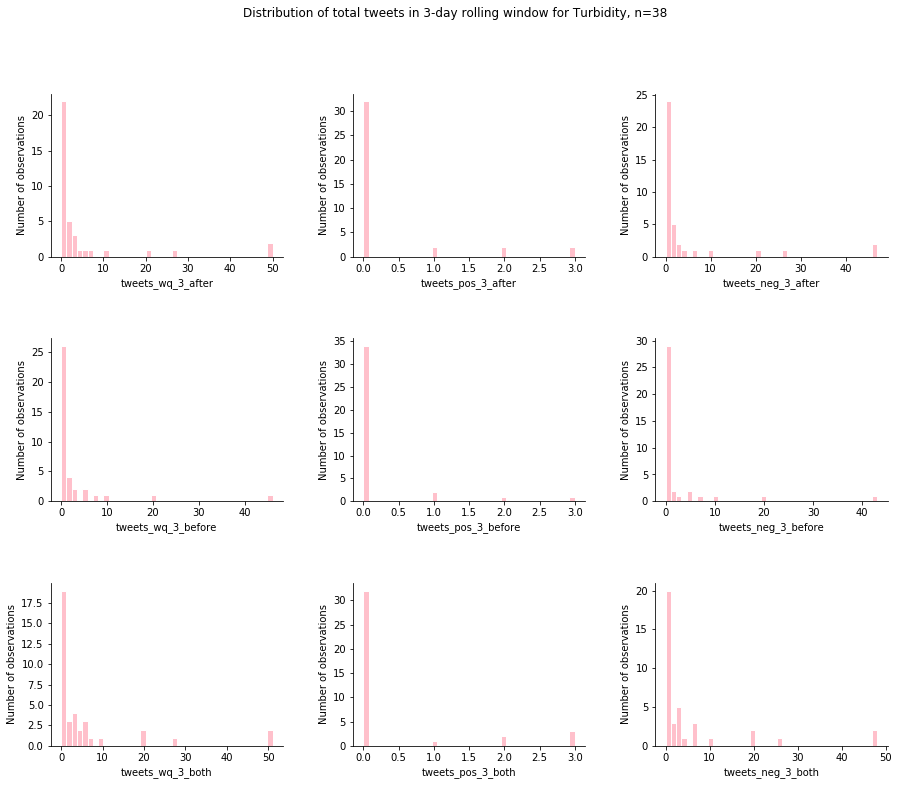

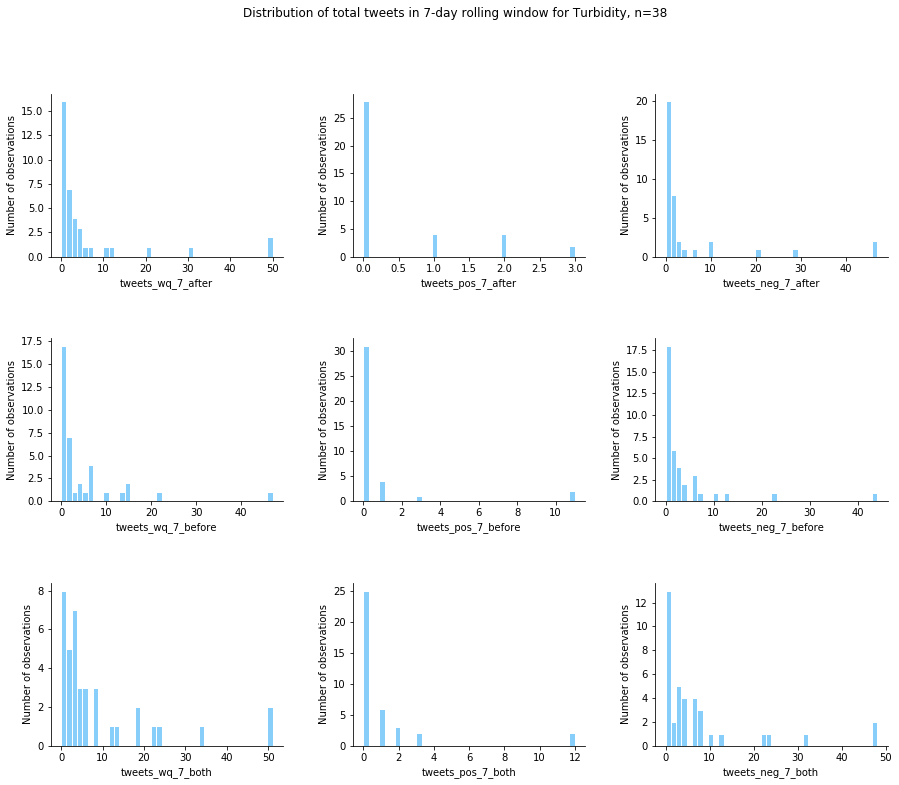

In [15]:
display(histogram_3days(df["t"], "Turbidity"));
display(histogram_7days(df["t"], "Turbidity"));

## Models 

In [ ]:
run_models()

# III. Chlorophyll a - Corrected for pheophytin

## Tweet distributions

In [ ]:
display(histogram_3days(df["c"], "Chlorophyll"));
display(histogram_7days(df["c"], "Chlorophyll"));

## Models 

In [ ]:
run_models()

# IV. Total Suspended Solids

## Tweet distributions

In [ ]:
display(histogram_3days(df["tss"], "Total suspended solids"));
display(histogram_7days(df["tss"], "Total suspended solids"));

## Models 

In [ ]:
run_models()

# V. Phytoplankton cell count

## Tweet distributions

In [ ]:
display(histogram_3days(df["tcc"], "Phytoplankton cell count"));
display(histogram_7days(df["tcc"], "Phytoplankton cell count"));

## Models 

In [ ]:
run_models()

# VI. Phytoplankton cell count (composite)

## Tweet distributions

In [ ]:
display(histogram_3days(df["tcc_c"], "Phytoplankton cell count (composite)"));
display(histogram_7days(df["tcc_c"], "Phytoplankton cell count (composite)"));

## Models 

In [ ]:
run_models()

# VII. Phytoplankton cell count (surface)

## Tweet distributions

In [ ]:
display(histogram_3days(df["tcc_s"], "Phytoplankton cell count (surface)"));
display(histogram_7days(df["tcc_s"], "Phytoplankton cell count (surface)"));

## Models 

In [ ]:
run_models()

# VIII. Phytoplankton biovolume 

## Tweet distributions

In [ ]:
display(histogram_3days(df["tb"], "Phytoplankton biovolume"));
display(histogram_7days(df["tb"], "Phytoplankton biovolume"));

## Models 

In [ ]:
run_models()

# IX. Phytoplankton biovolume (composite) 

## Tweet distributions

In [ ]:
display(histogram_3days(df["tb_c"], "Phytoplankton biovolume (composite)"));
display(histogram_7days(df["tb_c"], "Phytoplankton biovolume (composite)"));

## Models 

In [ ]:
run_models()

# X. Phytoplankton biovolume (surface)

## Tweet distributions

In [ ]:
display(histogram_3days(df["tb_s"], "Phytoplankton biovolume (surface)"));
display(histogram_7days(df["tb_s"], "Phytoplankton biovolume (surface)"));

## Models 

In [ ]:
run_models()

# XI. Cyanobacteria cell count

## Tweet distributions

In [ ]:
display(histogram_3days(df["ccc"], "Cyanobacteria cell count"));
display(histogram_7days(df["ccc"], "Cyanobacteria cell count"));

## Models 

In [ ]:
run_models()

# XII. Cyanobacteria cell count (composite)

## Tweet distributions

In [ ]:
display(histogram_3days(df["ccc_c"], "Cyanobacteria cell count (composite)"));
display(histogram_7days(df["ccc_c"], "Cyanobacteria cell count (composite)"));

## Models 

In [ ]:
run_models()

# XIII. Cyanobacteria cell count (surface)

## Tweet distributions

In [ ]:
display(histogram_3days(df["ccc_s"], "Cyanobacteria cell count (surface)"));
display(histogram_7days(df["ccc_s"], "Cyanobacteria cell count (surface)"));

## Models 

In [ ]:
run_models()

# XIV. Cyanobacteria biovolume 

## Tweet distributions

In [ ]:
display(histogram_3days(df["cb"], "Cyanobacteria biovolume"));
display(histogram_7days(df["cb"], "Cyanobacteria biovolume"));

## Models 

In [ ]:
run_models()

# XV. Cyanobacteria biovolume (composite) 

## Tweet distributions

In [ ]:
display(histogram_3days(df["cb_c"], "Cyanobacteria biovolume (composite)"));
display(histogram_7days(df["cb_c"], "Cyanobacteria biovolume (composite)"));

## Models 

In [ ]:
run_models()

# XVI. Cyanobacteria biovolume (surface)

## Tweet distributions

In [ ]:
display(histogram_3days(df["cb_s"], "Cyanobacteria biovolume (surface)"));
display(histogram_7days(df["cb_s"], "Cyanobacteria biovolume (surface)"));

## Models 

In [ ]:
run_models()

In [ ]:
names = ["c", "cb", "ccc", "sd", "tb", "tcc", "tss", "t", "tweets"]

In [ ]:
def poisson(wq, x, y):
    
    abc = df[wq]
    
    # Model formula
    formula = f"{y} ~ {x}"
    
    # Use Patsy package to carve out the x and y matrices for the ZIP model 
    Y, X = dmatrices(formula, abc, return_type='dataframe')
    
    # Fit the model
    model_p = sm.GLM(Y, X, family=sm.families.Poisson()).fit() #Fit the model using maximum likelihood
    
    return model_p.summary()

In [ ]:
# Create histogram

fig = plt.figure(figsize=(12,12))
i = -1

for num in range(1,10):

    ax1 = fig.add_subplot(3,3,num)
    ax1.hist(sd.iloc[:,i], color='lightskyblue', linewidth=1, edgecolor="white")
    ax1.set(xlabel = sd.columns[i], ylabel=f'Number of observations')
    i-=1

fig.suptitle(f"Tweets count distribution for {Secchi disk depth}, n={len(sd)}")
#fig.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

In [ ]:
# Calculate mean and variance (NOPE DONT DO IT)
# Fit zero-inflated poisson regression
# Fit negative binomial regression and Zero-inflated binomial regression (see why? in below link)
# Create residual vs fitter plots for both

In [ ]:
# example of doing poisson and negative 
# https://dius.com.au/2017/08/03/using-statsmodels-glms-to-model-beverage-consumption/

# we might not always need zero inflated model
# https://statisticalhorizons.com/zero-inflated-models

In [ ]:
df['sd']

In [24]:
# Import explanatory and response variables data
tweets = pd.read_csv("../../data/processed/regression/tweets_daily_final.csv")
sd = pd.read_csv("../../data/processed/regression/secchi_depth_final.csv")
t = pd.read_csv("../../data/processed/regression/turbidity_final.csv")
tss = pd.read_csv("../../data/processed/regression/total_suspended_solids_final.csv")
c = pd.read_csv("../../data/processed/regression/chlorophyll_final.csv")
tcc = pd.read_csv("../../data/processed/regression/total_cell_count_final.csv")
tb = pd.read_csv("../../data/processed/regression/total_biovolume_final.csv")
ccc = pd.read_csv("../../data/processed/regression/cyano_cell_count_final.csv")
cb = pd.read_csv("../../data/processed/regression/cyano_biovolume_final.csv")


In [25]:
# convert date column to datetime object
tweets['time'] = pd.to_datetime(tweets['time'])
sd['OBJECTID_1'] = pd.to_datetime(sd['OBJECTID_1'])
t['OBJECTID_1'] = pd.to_datetime(t['OBJECTID_1'])
tss['OBJECTID_1'] = pd.to_datetime(tss['OBJECTID_1'])
c['OBJECTID_1'] = pd.to_datetime(c['OBJECTID_1'])
tcc['OBJECTID_1'] = pd.to_datetime(tcc['OBJECTID_1'])
tb['OBJECTID_1'] = pd.to_datetime(tb['OBJECTID_1'])
ccc['OBJECTID_1'] = pd.to_datetime(ccc['OBJECTID_1'])
cb['OBJECTID_1'] = pd.to_datetime(cb['OBJECTID_1'])

In [26]:
sd['OBJECTID_1'] = pd.to_datetime(sd['OBJECTID_1'])

In [27]:
sd['OBJECTID_1'][0] 

Timestamp('2016-04-20 00:00:00')

In [28]:
idx = tweets['time'].eq(sd['OBJECTID_1'][0]).idxmax()
res = tweets.iloc[idx-7: idx+1]

print(res)

          time  water quality?  neg  pos
103 2016-04-13             0.0  0.0  0.0
104 2016-04-14             3.0  2.0  1.0
105 2016-04-15             0.0  0.0  0.0
106 2016-04-16             0.0  0.0  0.0
107 2016-04-17             0.0  0.0  0.0
108 2016-04-18             0.0  0.0  0.0
109 2016-04-19             0.0  0.0  0.0
110 2016-04-20             0.0  0.0  0.0


In [29]:
# create new columns to store tweet counts data

sd['tweets_neg_3_both'] = np.nan
sd['tweets_pos_3_both'] = np.nan
sd['tweets_wq_3_both']  = np.nan 

sd['tweets_neg_3_before'] = np.nan
sd['tweets_pos_3_before'] = np.nan
sd['tweets_wq_3_before']  = np.nan 

sd['tweets_neg_3_after'] = np.nan
sd['tweets_pos_3_after'] = np.nan
sd['tweets_wq_3_after']  = np.nan


sd['tweets_neg_7_both'] = np.nan
sd['tweets_pos_7_both'] = np.nan
sd['tweets_wq_7_both']  = np.nan

sd['tweets_neg_7_before'] = np.nan
sd['tweets_pos_7_before'] = np.nan
sd['tweets_wq_7_before']  = np.nan

sd['tweets_neg_7_after'] = np.nan
sd['tweets_pos_7_after'] = np.nan
sd['tweets_wq_7_after']  = np.nan


# Iterate over each row in wq variable
for index, row in sd.iterrows():
    
    # get dates for which we have water quality measurements
    date_wq = row['OBJECTID_1']
    
    # get index of the row with same date in the tweets data
    tweets_index = tweets['time'].eq(date_wq).idxmax()
    
    # get tweets info from 3 & 7 days before and after the date on which water quality was measured
    tweets_result_3_both = tweets.iloc[tweets_index-3: tweets_index+4]
    tweets_result_3_before = tweets.iloc[tweets_index-3: tweets_index+1]
    tweets_result_3_after = tweets.iloc[tweets_index: tweets_index+4]
    
    tweets_result_7_both = tweets.iloc[tweets_index-7: tweets_index+8]
    tweets_result_7_before = tweets.iloc[tweets_index-7: tweets_index+1]
    tweets_result_7_after = tweets.iloc[tweets_index: tweets_index+8]
    
    # assign the sum of negative tweets
    sd.loc[index, 'tweets_neg_3_both'] = tweets_result_3_both['neg'].sum() 
    sd.loc[index, 'tweets_pos_3_both'] = tweets_result_3_both['pos'].sum()
    sd.loc[index, 'tweets_wq_3_both'] = tweets_result_3_both['water quality?'].sum()
    
    sd.loc[index, 'tweets_neg_3_before'] = tweets_result_3_before['neg'].sum() 
    sd.loc[index, 'tweets_pos_3_before'] = tweets_result_3_before['pos'].sum()
    sd.loc[index, 'tweets_wq_3_before'] = tweets_result_3_before['water quality?'].sum()
    
    sd.loc[index, 'tweets_neg_3_after'] = tweets_result_3_after['neg'].sum() 
    sd.loc[index, 'tweets_pos_3_after'] = tweets_result_3_after['pos'].sum()
    sd.loc[index, 'tweets_wq_3_after'] = tweets_result_3_after['water quality?'].sum()
    
    sd.loc[index, 'tweets_neg_7_both'] = tweets_result_7_both['neg'].sum() 
    sd.loc[index, 'tweets_pos_7_both'] = tweets_result_7_both['pos'].sum()
    sd.loc[index, 'tweets_wq_7_both'] = tweets_result_7_both['water quality?'].sum()
    
    sd.loc[index, 'tweets_neg_7_before'] = tweets_result_7_before['neg'].sum() 
    sd.loc[index, 'tweets_pos_7_before'] = tweets_result_7_before['pos'].sum()
    sd.loc[index, 'tweets_wq_7_before'] = tweets_result_7_before['water quality?'].sum()
    
    sd.loc[index, 'tweets_neg_7_after'] = tweets_result_7_after['neg'].sum() 
    sd.loc[index, 'tweets_pos_7_after'] = tweets_result_7_after['pos'].sum()
    sd.loc[index, 'tweets_wq_7_after'] = tweets_result_7_after['water quality?'].sum()
    
    
#     print(date_wq)
#     print(tweets_result)

In [30]:
sd.head(50)

,OID,OBJECTID_1,COUNT,AREA,MEAN,STD,SUM,X25.,X50.,X75.,...,tweets_wq_3_after,tweets_neg_7_both,tweets_pos_7_both,tweets_wq_7_both,tweets_neg_7_before,tweets_pos_7_before,tweets_wq_7_before,tweets_neg_7_after,tweets_pos_7_after,tweets_wq_7_after
0,0,2016-04-20,27254.0,0.036135,0.326584,6.522402e-02,8900.717586,0.292608,0.326837,0.379791,...,1.0,3.0,1.0,4.0,2.0,1.0,3.0,1.0,0.0,1.0
1,1,2016-05-25,27254.0,0.036135,0.200000,0.000000e+00,5450.800081,0.200000,0.200000,0.200000,...,0.0,2.0,0.0,2.0,1.0,0.0,1.0,1.0,0.0,1.0
2,2,2016-06-30,27254.0,0.036135,0.200000,0.000000e+00,5450.800081,0.200000,0.200000,0.200000,...,0.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,2.0
3,3,2017-05-10,27254.0,0.036135,0.266793,1.052118e-02,7271.177156,0.256585,0.267754,0.272464,...,0.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,1.0,3.0
4,4,2017-05-11,27254.0,0.036135,0.271572,1.186248e-02,7401.413938,0.265434,0.269956,0.278423,...,0.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,1.0,3.0
5,5,2017-06-15,27254.0,0.036135,0.321752,4.414198e-02,8769.025205,0.300185,0.308336,0.364803,...,0.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0
6,6,2017-07-11,27254.0,0.036135,0.214709,3.412158e-02,5851.680627,0.201629,0.212833,0.237013,...,27.0,32.0,0.0,34.0,3.0,0.0,5.0,29.0,0.0,30.0
7,7,2017-08-07,27254.0,0.036135,0.289606,3.882226e-02,7892.927859,0.274076,0.288600,0.306758,...,3.0,6.0,12.0,19.0,4.0,11.0,15.0,2.0,2.0,5.0
8,8,2017-08-08,27254.0,0.036135,0.265372,3.149683e-02,7232.436012,0.249463,0.263379,0.284706,...,4.0,6.0,12.0,19.0,4.0,11.0,15.0,2.0,1.0,4.0
9,9,2017-09-11,27254.0,0.036135,0.290509,3.197386e-02,7917.524259,0.275228,0.296750,0.305719,...,1.0,3.0,0.0,3.0,1.0,0.0,1.0,2.0,0.0,2.0


In [31]:
sd.columns = sd.columns.str.replace(".", "")

In [32]:
# Regression - Zero inflated poisson regression (zip)
formula = "tweets_neg_3_both ~ X75"

# Use Patsy package to carve out the X and y matrices for ZIP model 
y, x = dmatrices(formula, sd, return_type='dataframe')

In [ ]:
# https://towardsdatascience.com/an-illustrated-guide-to-the-zero-inflated-poisson-model-b22833343057
model_zip = sm.ZeroInflatedPoisson(endog=y, exog=x, exog_infl=x, inflation='logit').fit(method='newton') #Fit the model using maximum likelihood
model_zip.summary()

In [ ]:
model.params

In [ ]:
# Regression - Zero Inflated Negative Binomial
# explantion abt zero inflation https://stats.stackexchange.com/questions/77745/zero-inflated-negative-binomial/257900
model_zinb = sm.ZeroInflatedNegativeBinomialP(endog=y, exog=x, exog_infl=x, inflation='logit').fit(method='ncg')
model_zinb.summary()

In [23]:
sd.head()

AttributeError: 'list' object has no attribute 'head'

In [34]:
# Negative Binomial
model_p = sm.GLM(y, x, family=sm.families.Poisson()).fit()
model_p.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      tweets_neg_3_both   No. Observations:                   38
Model:                            GLM   Df Residuals:                       36
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -260.25
Date:                Sun, 07 Feb 2021   Deviance:                       441.59
Time:                        19:56:20   Pearson chi2:                     720.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5721      0.204     17.550      0.000       3.173       3.971
X75           -7.7967      0.935     -8.341      0.000      -9.629      -5.965
==============================================================================
"""

In [35]:
print(model_p.mu)
print(len(model_p.mu))

[ 1.84218021  7.48376053  7.48376053  4.25354061  4.06044186  2.07053739
  5.60776717  3.25558303  3.86631463  3.28207154  5.82362738  7.61787628
  5.23431776  7.43097574 16.32029085  6.6998727  12.55963451  5.11937474
  8.50120627  3.43171999  9.66553913  8.08956814  7.48376053  6.07489431
 11.25345059  2.84635143  0.04541661  1.2600313   0.11286375  1.71446446
  3.31094938  3.69373135  4.30936939  7.4837607   1.83918527  5.06775824
 16.32029104  7.4837607 ]
38


In [36]:
sd_copy = sd.copy()
sd_copy['BB_LAMBDA'] = model_p.mu

In [37]:
sd_copy['AUX_OLS_DEP'] = sd_copy.apply(lambda x: ((x['tweets_neg_3_both'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)

In [38]:
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""

In [39]:
aux_olsr_results = smf.ols(ols_expr, sd_copy).fit()

In [40]:
print(aux_olsr_results.params)

BB_LAMBDA    2.166812
dtype: float64


In [41]:
aux_olsr_results.tvalues #seeing the significant t-value for 95 percentile it is significant

BB_LAMBDA    1.945057
dtype: float64

In [42]:
nb2_training_results = sm.GLM(y, x,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()

In [43]:
print(nb2_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      tweets_neg_3_both   No. Observations:                   38
Model:                            GLM   Df Residuals:                       36
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -95.137
Date:                Sun, 07 Feb 2021   Deviance:                       48.908
Time:                        19:57:09   Pearson chi2:                     45.7
No. Iterations:                    34                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5311      0.573      4.416      0.0

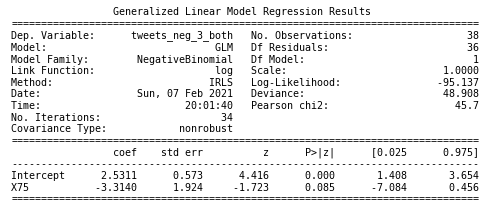

In [61]:
# print out
# Export model as img
plt.rc('figure', figsize=(7,3))
plt.text(0.01, 0.05, str(nb2_training_results.summary()),
{'fontsize':22}, fontproperties =  'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig('../../output/regression/output.png')

In [ ]:
wq='sd'
x='X75'
y='tweets_neg_3_both'

In [ ]:
temp = df[wq]
formula = f"{y} ~ {x}"
Y, X = dmatrices(formula, temp, return_type='dataframe')
model_p = sm.GLM(Y, X, family=sm.families.Poisson()).fit()
temp2 = temp.copy()
temp2['rate_lambda'] = model_p.mu
temp2['aux_ols_dependent'] = temp2.apply(lambda t: ((t[y] - t['rate_lambda'])**2 - t['rate_lambda']) / t['rate_lambda'], axis=1)
ols_formula = """aux_ols_dependent ~ rate_lambda - 1"""

model_aux_olsr = smf.ols(ols_formula, temp2).fit()

In [ ]:
def poisson(wq, x, y):
    
    temp = df[wq]
    
    # Model formula
    formula = f"{y} ~ {x}"
    
    # Use Patsy package to carve out the x and y matrices for the ZIP model 
    Y, X = dmatrices(formula, temp, return_type='dataframe')
    
    # Fit the model
    model_p = sm.GLM(Y, X, family=sm.families.Poisson()).fit() #Fit the model using maximum likelihood
    
    return model_p, Y, X

In [ ]:
def negative_binomial(wq, x, y):
    
    poisson(wq, x, y)
    
#     temp = df[wq]
    
#     # Model formula
#     formula = f"{y} ~ {x}"
    
#     # Use Patsy package to carve out the x and y matrices for the ZIP model 
#     Y, X = dmatrices(formula, temp, return_type='dataframe')
    
#     # Fit the model
#     model_p = sm.GLM(Y, X, family=sm.families.Poisson()).fit() #Fit the model using maximum likelihood
    
    # Obtain rate vector from Poisson model
    temp2 = temp.copy()
    temp2['rate_lambda'] = model_p.mu
    
    # Auxiliary OLS regression to find α for the NB2 model
    # Calculate the dependent variable
    temp2['aux_ols_dependent'] = temp2.apply(lambda t: ((t[y] - t['rate_lambda'])**2 - t['rate_lambda']) / t['rate_lambda'], axis=1)
    
    # Using the α as dependent variable in an OLS regression model
    ols_formula = """aux_ols_dependent ~ rate_lambda - 1"""
    
    # Fitting the OLS regression model
    model_aux_olsr = smf.ols(ols_formula, temp2).fit()
    
    # The model coefficient is the alpha parameter for our negative binomial
    alpha = model_aux_olsr.params[0]
    
    # Get the associate t-value to determine significance
    t_value = model_aux_olsr.tvalues[0]
    
    # Caluclate degrees of freedom (number of observations - regression variables - dispersion variable)
    deg_freedom = len(temp2) - 1 - 1
    
    # Determine t critical value at 95% significance value
    t_critical = scipy.stats.t.ppf(q=1-.05,df=deg_freedom)
    
    # If the alpha is significant, negative binomial can be a better fit than poisson
    if (t_value > t_critical):
        print ("Alpha parameter of negative binomial regression is significant")
    else:
        print ("Alpha parameter of negative binomial regression is not significant")
        
    # Fit negative binomial regression model
    model_nb = sm.GLM(Y, X,family=sm.families.NegativeBinomial(alpha=alpha)).fit()
    
    return model_nb.summary()

In [ ]:
negative_binomial('sd', 'X75', 'tweets_neg_3_both')

In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets



In [ ]:
def f(x):
    return x
interact(f, x=[('oneeeeeeeeeeeeeeeeeeeeffffffffffddddddddddddddddddddddddd', '10'), ('two', 20)]);

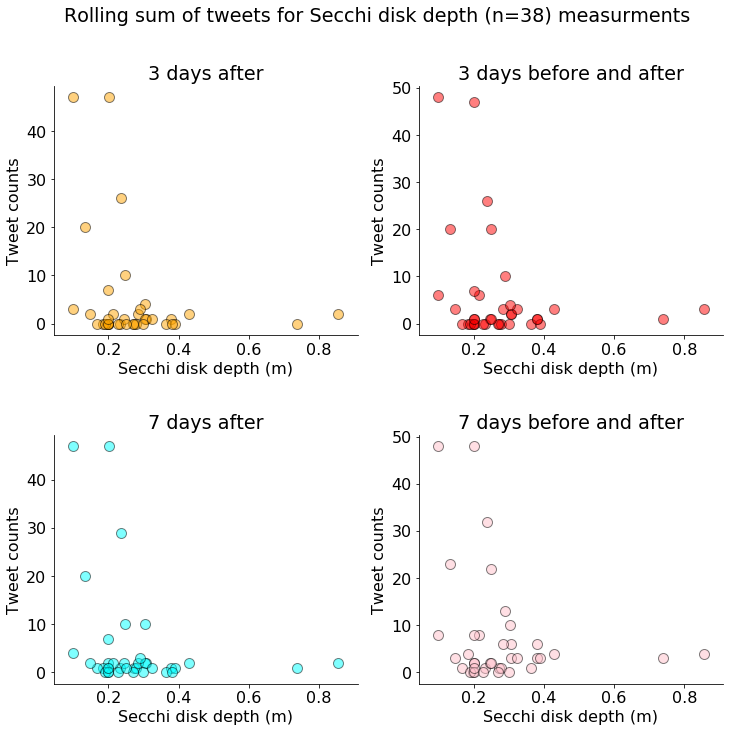

In [77]:
fig = plt.figure(figsize=(12,11))

ax1 = fig.add_subplot(2, 2, 1)
ax1.scatter(df['sd']['X75'], df['sd']['tweets_neg_3_after'], color='orange', 
           alpha=0.5, s=100, edgecolor='black')
ax1.set(xlabel="Secchi disk depth (m)", ylabel='Tweet counts',
       title="3 days after")

ax1 = fig.add_subplot(2, 2, 2)
ax1.scatter(df['sd']['X75'], df['sd']['tweets_neg_3_both'], color='red', 
           alpha=0.5, s=100, edgecolor='black')
ax1.set(xlabel="Secchi disk depth (m)", ylabel='Tweet counts', 
        title="3 days before and after")

ax1 = fig.add_subplot(2, 2, 3)
ax1.scatter(df['sd']['X75'], df['sd']['tweets_neg_7_after'], color='cyan', 
           alpha=0.5, s=100, edgecolor='black')
ax1.set(xlabel="Secchi disk depth (m)", ylabel='Tweet counts',
       title="7 days after")

ax1 = fig.add_subplot(2, 2, 4)
ax1.scatter(df['sd']['X75'], df['sd']['tweets_neg_7_both'], color='pink', 
           alpha=0.5, s=100, edgecolor='black')
ax1.set(xlabel="Secchi disk depth (m)", ylabel='Tweet counts',
       title="7 days before and after")


fig.suptitle(f"Rolling sum of tweets for Secchi disk depth (n={len(df['sd'])}) measurments")
#fig.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.2)
plt.savefig("../../output/bivariate plots/sd_plot.png", bbox_inches = 'tight')
plt.show();